# Analysis and recommendation of Books

## 1. Introduction

There are thousands of books that have become popular over time and that thanks to them, we can escape from the real world for a few hours. 

How many times have you taken to decide the next book you were going to read? How many times have you doubted whether to choose Harry Potter or Twilight? 


<img src="./Images/twobooks.png" alt="CB" style="width: 300px;"/>
<br>


There have been good recommender systems for movies or music, but not for books. 

That is why in this post we will try to analyze the famous dataset from Kaggle, <a href="https://www.kaggle.com/zygmunt/goodbooks-10k"> GoodBooks-10k Dataset</a>. As written in the description, you can find the cleaned dataset in the next link: <a href="https://github.com/zygmuntz/goodbooks-10k"> Cleaned goodbooks-10k dataset</a>. With this data, we will try to recommend a book. 


As we will see, this dataset contains ratings of almost ten thousand popular books taken from the well-known page _GoodReads.com_.
The main idea is analyzing the dataset to get a fair idea about the relationship between the multiple attributes a book might have and the relationship between the users and the score that they gave to each book. 

Following topics would be covered as an outline for this article:

- Data cleaning and preparation
- Analysis of the data
- Creating a recommender system:
    - Content-based recommender.
    - Collaborative Filtering.

### Dependencies

For this project we will need to install the next libraries:

* **Pandas and Numpy**: will help us to treat the data.
* **MatplotLib and Seaborn:** to visualize the data in different ways.
* **SkLearn:** Provide tools to train our models.
* **Surprise:** Provide tools to build and analyze recommender systems. 

In [1]:
# Imports
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, SVD, evaluate

import warnings
warnings.filterwarnings("ignore")

## 2. Data Information

The first step of all Machine Learning problems is reading our data and understand it, so in this section, we are going to visualize and understand the data we have.

If it is necessary, we will also clean our data and prepare it for the analysis.

In [2]:
# Load Datasets
books = pd.read_csv('Dataset/books.csv')
ratings = pd.read_csv('Dataset/ratings.csv')
tags = pd.read_csv('Dataset/tags.csv')
book_tags = pd.read_csv('Dataset/book_tags.csv')

In [3]:
# Checking the shapes of the datasets
print("The books dataset has:", books.shape[0], "entries.")
print("The ratings dataset has:", ratings.shape[0], "entries.")
print("The tags dataset has:", tags.shape[0], "entries.")
print("The book_tags dataset has:", book_tags.shape[0], "entries.")

The books dataset has: 10000 entries.
The ratings dataset has: 5976479 entries.
The tags dataset has: 34252 entries.
The book_tags dataset has: 999912 entries.


As we see, we have a lot of information on these datasets. But we are going to go deeper in each one later. 

Now we are going to check if we have missing values in our data.

In [4]:
# Check for missing Values
print("Is there NaN values? \n On books dataset:",  books.isnull().values.any(), 
      "\n On ratings dataset:", ratings.isnull().values.any(),
     "\n On tags dataset:", tags.isnull().values.any(),
     "\n On book_tags dataset:", book_tags.isnull().values.any())

Is there NaN values? 
 On books dataset: True 
 On ratings dataset: False 
 On tags dataset: False 
 On book_tags dataset: False


As we see there are no missing values in most of the datasets but there are missing values in the books one that may perhaps complicate things for us in the future. 

Therefore we will see what attributes have NaNs values.

In [5]:
null_counts = books.isnull().sum()
null_counts[null_counts>0]

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

For now, we are not going to eliminate the values of NaN because we do not know if they will affect us since the attributes such as the ISBN / ISBN13 do not provide information to recommend a book. 
On the other hand, you can search for the book by title if the original is not found. If we see that we need it, we will deal with them later. 

As the year of the publication is concerned, we are going to check what is the range of years.

In [6]:
print("Oldest book: ", books['original_publication_year'].min())
print("Newer book: ", books['original_publication_year'].max())

Oldest book:  -1750.0
Newer book:  2017.0


As we can see, it is indicated to us that this attribute has negative values, when they do not make sense, so we are going to eliminate them as well as NaNs values. 

In [7]:
# Delete NaN values of original_publication_year
for x in ["original_publication_year"]:
    books = books[books[x].notnull()]

# Delete negative values
books = books[(books['original_publication_year'] >= 0)]
print("Now we have", books.shape[0], "entrances.")

Now we have 9948 entrances.


Once we have checked this, let us take a look at the data for each dataset. 

### Books dataset

In [8]:
# Print the head of the books dataset.
pd.set_option('display.max_columns', None)
books.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


When we look at some examples, we can see that there are some attributes that we don't need for the analysis, such as:

- _ratings_1, ratings_2, ratings_3, ratings_4, ratings_5_ (We don't need these attributes because we have an average of them in another one so, we will use only this one.)
- _image_url_
- _small_image_url_
- _isbn_ , _isbn13_
- _best\_book\_id_
- _work\_id_
- _work_ratings_count_


So we are going to delete them.

In [9]:
# Drop the columns that we don't need.
books.drop(['best_book_id','work_id','work_ratings_count','ratings_1', 'ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url','isbn','isbn13'], axis=1,inplace=True)

### Ratings dataset

As previously discussed, there is also a dataset with user scores for each book. Let's explore what attributes it has and what useful information it gives us. 

In [10]:
# Print head of the ratings dataset
ratings.head(3)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


In [11]:
print("The ratings can be:", ratings.rating.unique())

The ratings can be: [5 4 3 2 1]


We can take a look at how many ratings have each book and how many ratings have each user. 

In [12]:
# Grouping by the book_id to know how many ratings have each book
rating_book = ratings.groupby('book_id').book_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per book is:", rating_book.min())
print("The maximum number of ratings per book is:", rating_book.max())

The minimum number of ratings per book is: 8
The maximum number of ratings per book is: 22806


In [13]:
rating_user = ratings.groupby('user_id').user_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per user is:", rating_user.min())
print("The maximum number of ratings per user is:", rating_user.max())

The minimum number of ratings per user is: 19
The maximum number of ratings per user is: 200


### Book_tags & tags dataset

These two datasets are related to tags, and to better understand them, let's take a look at them. 

In [14]:
book_tags.head(3)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


In [15]:
tags.sample(3)

,tag_id,tag_name
22578,22578,oulipo
31345,31345,tv-related
6490,6490,celebrity-bios


As we can see, the first one contains all the tags_ids users have assigned to that book and the corresponding tag_counts, while in the second, we have the tag_name corresponding to tag_id.

We can merge these two datasets into one grouping by the 'tag_id' to simplify them. 

Also, we can merge with the books dataset to know exactly for each book which tags it has.

In [16]:
# Merge the two datasets grouping by the tag_id. 
data = pd.merge(book_tags, tags, left_on='tag_id', right_on='tag_id', how='inner')

titles = books[['book_id','title','goodreads_book_id','authors']]

# Merge the book dataset with the new one to know the title and the author
data = pd.merge(titles, data, left_on='goodreads_book_id', right_on='goodreads_book_id')
data.head(3)

,book_id,title,goodreads_book_id,authors,tag_id,count,tag_name
0,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,30574,11314,to-read
1,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11305,10836,fantasy
2,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11557,50755,favorites


## 3. Data Analysis

Once we have understood and observed our data, we will proceed to analyze it.

First, we are going to take a look at the information we have about some interesting attributes:

In [17]:
books[['book_id','original_publication_year','average_rating','ratings_count']].describe()

,book_id,original_publication_year,average_rating,ratings_count
count,9948.000000,9948.000000,9948.000000,9.948000e+03
mean,5001.972758,1989.688983,4.002050,5.400569e+04
std,2886.580085,63.459165,0.254411,1.576062e+05
min,1.000000,8.000000,2.470000,2.716000e+03
25%,2502.750000,1990.000000,3.850000,1.356975e+04
50%,5006.500000,2004.000000,4.020000,2.115850e+04
75%,7502.250000,2011.000000,4.180000,4.105350e+04
max,10000.000000,2017.000000,4.820000,4.780653e+06


In [18]:
books[books['original_publication_year'] == 8]

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count
2365,2366,1715,437,"Ovid, David Raeburn, Denis Feeney",8.0,Metamorphoses,Metamorphoses,eng,4.03,42590,1121


With this information, we can observe interesting aspects: 


-  The oldest book is one from year 8. This may seem strange to us since it is old, but if we look at the title of this book, it is one called "Metamorphosis" and, it was indeed written in AD 8. 

- We can observe that the minimum value for the average rating is 2.47 that it is not so low and the maximum's 4.82. On the other hand, we can see that the Standard Deviation (std), which shows us how dispersed are the values of the attributes from its average, is approximately 0.25. 

Next, we are going to observe the distribution of the books that we find in the dataset by the publication year. 

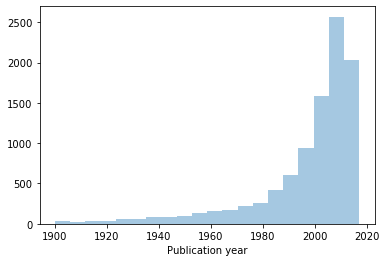

In [19]:
# Function that plots the distribution of the books by the year.
def plot_yearDistribution():
    # Filter booms written from 1900
    years_filter = books[(books['original_publication_year'] >= 1900)]
    
    #Plot the distribution of the books by the publication year.
    sns.distplot(years_filter['original_publication_year'], kde=False, bins=20)
    plt.xlabel("Publication year")
    plt.show()

plot_yearDistribution()

We can observe from the plot above that most of the books that we find in the dataset are from the 2000s, so we can conclude that most of them are almost new.


And, what if we look at the distribution of the ratings?

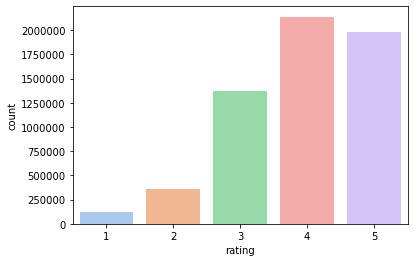

In [20]:
sns.countplot(data=ratings, x ='rating', palette='pastel')
plt.show()

As we can see in the plot, people tend to give quite positive ratings to books. Most of the ratings are between 3 and 5, while very few ratings are between 1 and 2. We can make two hypotheses from this:

1. People tend to vote only on the books they liked.
2. People are biased towards positive reviews. 

Let's now, see which tags are the most popular.

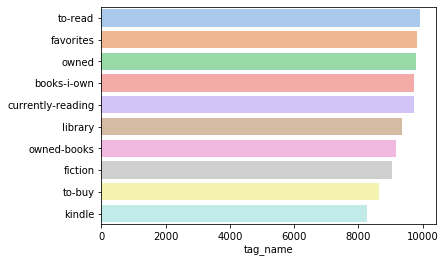

In [21]:
# Count number of times each tag appears and sort them.
top_tags = data['tag_name'].value_counts(ascending = False).head(10)

sns.barplot(x = top_tags, y=top_tags.index, palette='pastel')
plt.show()

As we can see we have a lot of different tags, and there is not the only genre such as "fiction" or "comedy", but we can also find tags such as "favorites" or "to-read" which in this case are the two most popular.

Next, we can see, whether we can find any association of features with a book's rating. Let's plot the correlation matrix between the book's average rating and some other variables such as the count of books, the publication year, number of ratings given, and the worktext review count. 

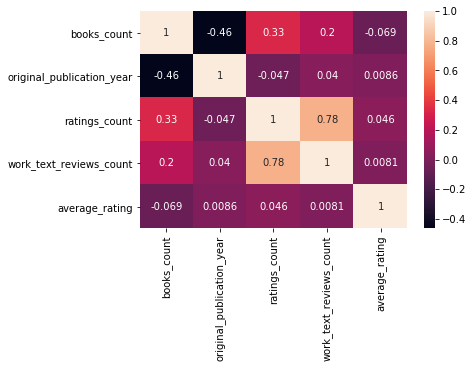

In [22]:
corr = books[['books_count','original_publication_year','ratings_count','work_text_reviews_count','average_rating']].corr()
sns.heatmap(corr,annot=True)
plt.show()

We see only small correlations between the attributes and the average rating. It indicates that there are no strong relationships between the rating a book receives and the other variables as rating counts, etc. 

Let's now look at the 5 most popular books and the 5 with the highest average rating. Do you think it will be the same books or differents because these two attributes don't have a high correlation? 

In [23]:
pd.set_option('display.max_colwidth', -1)
books[['title','ratings_count']].sort_values(by=['ratings_count'], ascending=False).head(5)

,title,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",4780653
1,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4602479
2,"Twilight (Twilight, #1)",3866839
3,To Kill a Mockingbird,3198671
4,The Great Gatsby,2683664


In [24]:
books[['title','average_rating']].sort_values(by=['average_rating'], ascending=False).head(5)

,title,average_rating
3627,The Complete Calvin and Hobbes,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.77
861,"Words of Radiance (The Stormlight Archive, #2)",4.77
8853,Mark of the Lion Trilogy,4.76
7946,ESV Study Bible,4.76


As we expected, if a book is the most popular (because a lot of people have left their rating) it doesn't mean that it is the book with the best average rating. 

But, the first book of Harry Potter is the second most popular, and at the same time, all the Harry Potter books together are the second in terms of the average rating.

## 4. Recommender systems

To achieve our objective, we are going to reproduce the two most popular recommender systems: Content-based filtering and Collaborative Filtering.

## 4.1. Content-Based

The Content-based recommender suggests similar items based on a particular item. This system uses item metadata such as genre, description of a book, etc. to make these recommendations... 

**What means content in our case?**

In our case, we will use the tags that a user-provided to a book. So, the idea of content-based filtering is to understand what the users like, and if a person likes a particular book, he or she will also like a book that is similar to it. 

To understand this better, I will explain an example. 

> Imagine that your favorite book has the following tags: "Romantic, fiction, vampires". The system will recommend a book that has similar tags. 

<img src="./Images/CB.png" alt="CB" style="width: 300px;"/>

**How it works?**

First of all, the system will find the similarity between all pairs of books, then it uses the most similar books to a user's already-rated books to generate a list of recommendations in the recommendation stage.

Therefore, to find the similarity between books we will use all the tags of the books and we will compute the **TFIDF (Term Frequency-Inverse Document Frequency)** vector for each document (each list of tags).


TF-IDF is from the sub-area of Natural language Processing. It is going to count the occurrence of each word in a document and weight them by importance, and finally calculate a score for that document. 

In other words, it is a measure used to evaluate how important a word is to a document in a document corpus. The importance of the word increases proportionally to the number of times a word appears in the document but, is offset by the frequency of the word in the documents. 

This will give us a matrix where each column represents a word in the list of tags vocabulary and each row represents a book. 

With this matrix, calculate the cosine similarity between two vectors. Each vector contains keywords (the tags) that define each book. This function is the next one:


<img src="./Images/cosine.png" alt="Cosine" style="width: 400px;"/>

By applying this definition, the similarity will be a number bounded between 0 and 1 that tells us how much the two vectors are similar.

### Data preparation

To create our recommender system, we need to prepare our data for it. 

The first step needed is to create a list of all the tags that a book has. Then, we will add this list to our dataset in a new column named "Tags". 

In [25]:
# For each book, join all their tags
list_tags = data.groupby(by='goodreads_book_id')['tag_name'].apply(set).apply(list)

# Append this list of tags on the books dataset
books['tags'] = books['goodreads_book_id'].apply(lambda x: ' '.join(list_tags[x]))

In [26]:
pd.reset_option('max_colwidth')
books.head(3)

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count,tags
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,155254,dystopian ebook sci-fi-fantasy 5-star audio fa...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,75867,ebook mystery sci-fi-fantasy audio favourite r...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,95009,ebook romantic sci-fi-fantasy ya-paranormal di...


Let's create the functions that we will need to create our content-based recommender system.

In [27]:
# Function to get the index of the book given its title. 
def get_book_id(book_title):
    index = books.index[books['original_title'] == book_title].to_list()
    if index:
        return index[0]
    else:
        return None

# Function to get the title of a book given its id.
def get_book_title(book_id):
    title = books.iloc[book_id]['original_title']
    return title

# Function that takes the book title and returns the most similar books.
def get_similar_books(title, n=5):
    
    # Get the book id
    book_id = get_book_id(title)
    
    if book_id is None:
        print("Book not found.")
    else:
        
        # Get the pariwsie similarity scores of all books with that book
        book_similarities = list(enumerate(similarities[book_id]))
        
        # Sort the books based on the similarity scores
        book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
        
        # Get the scores of the 5 most similar book
        most_similar_books = book_similarities[1:1+n]
        most_similar_books = list(map(lambda x: (get_book_title(x[0]), round(x[1], 2)), most_similar_books))
        
        most_similar_books_df = pd.DataFrame(most_similar_books, columns=['Title', 'Similarity'])
        print("For this book we will recommand you:\n")
        
        return most_similar_books_df.style.hide_index()

### Model creation

To build the TF-IDF matrix we will use the **TfIdfVectorizer** from _scikit-learn_.

First of all, we will define the TF-IDF Vectorizer Object and also remove all the english stop words such as "the", "and", "or", etc.

Then, we have to construct the required TF-IDF matrix by fitting and transforming the data (in our case, the column named 'tags').

In [28]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(books['tags'])

Now, as we said, we will use the cosine similarity score. 

In [29]:
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [30]:
get_similar_books("The Hunger Games")

For this book we will recommand you:



Title,Similarity
Catching Fire,0.960000
Mockingjay,0.940000
The Hunger Games Box Set,0.900000
Divergent,0.740000
Delirium,0.670000


These results are very great! If you look at the first two books, as expected, are the second and third parts of the trilogy "The Hunger Games". Then, it shows with a 74 percent similarity, the first book of the saga Divergent, that personally, I read it and I agree that these two are similar. 

## 4.2. Collaborative-Filtering

The Collaborative-Filtering can be classified into two types: User-based or Item-based. 

We will reproduce the User-Based since the idea of the Item-Based is the same as the Content-Based.

The main idea of User-Based Collaborative-Filtering User-Based is that this method recommends you a book by using the similarities between users. 

> Imagine that you and your friend Lara have a similar interest in books and almost always you like and dislike the same books. Now, if you don't know what book to read next, it is obvious that you will ask her to recommend a book. That is what this recommender system will do. 

<img src="./Images/cf.png" alt="CF" style="width: 350px;"/>

**How will it do it?**

We will use the Surprise library from Scikit, which builds and analyzes recommender systems. It provides various ready-to-use prediction algorithms such as matrix factorization-based (SVD). Also, various similarity measures. 

We are going to use the SVD algorithm that is equivalent to probabilistic matrix factorization it allows us to discover the latent features underlying the interactions between users and items. 

### Data preparation

To create our recommender system, we need to prepare our data for it. 

Since we have a lot of data and for computational cost reasons we will only deal with the books that were released from the year 2000 so we will recommend books from this century. 

In [31]:
# We keep only the books from the year 2000.
newer_books = books[books['original_publication_year'] > 2000]

df_books = newer_books[['book_id','original_title', 'title']]

# We are left with the ratings that have been made to the books from the year 2000.
df_ratings = ratings[ratings.book_id.isin(df_books.book_id)]

On the other hand, we will keep only the users who have voted more than 100 books. 

Then, the data we have must have the following attributes: _user\_id, _book\_id_, _rating_. 

Once we have it, we can proceed to create the recommender system.

In [32]:
# Count the users that has voted more than 100 times. 
user_counts = df_ratings['user_id'].value_counts()
df_ratings = df_ratings[df_ratings['user_id'].isin(user_counts[user_counts >= 100].index)]

In [33]:
df_titles = df_books[['book_id','title']]
df_titles.set_index('book_id', inplace = True)

In [34]:
# Function that takes the user id and returns the most similar books. 
def recommend_books(user_id):
    
    # Getting all the ratings that has done the user
    user = df_ratings[df_ratings['user_id'] == user_id]
    user = user.join(df_titles)['title']
    
    user = df_titles.copy()
    user = user.reset_index()
    
    # We get the books that the user has not yet read. 
    user = user[~user['book_id'].isin(df_books)]
    
    # We check the predicted score using the predict function and getting the estimation.
    user['estimate_score'] = user['book_id'].apply(lambda x: svd.predict(user_id, x).est)
    
    # Sort the books by the estimate score that the predict returns.
    user = user.drop('book_id', axis=1)
    user = user.sort_values('estimate_score', ascending=False)
    
    return user.head(5)

### Model creation

Now, it's time to start using the Surprise package. 

The first thing we need to do is to load the dataset and this is done using the Reader class. 

Surprise library provides us a way to do cross-validation by dividing the data into different folds right from the beginning. The idea behind this is to apply cross-validation to the data where training is done on all fold except one and scoring is done on the remaining fold. 

The folds of data are done using the split function.

In [35]:
reader = Reader()

data = Dataset.load_from_df(df_ratings[['user_id','book_id','rating']], reader)
data.split(n_folds=5)

The way of training is similar to other machine learning approaches. It will try to predict the rating of a certain user-book combination and it will compare that prediction to the actual prediction. 

The difference between the actual and the predicted rating is measured using classical error measurements such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

In [36]:
svd = SVD()
evaluate(svd, data, measures=['RMSE','MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8101
MAE:  0.6265
------------
Fold 2
RMSE: 0.8154
MAE:  0.6312
------------
Fold 3
RMSE: 0.8154
MAE:  0.6308
------------
Fold 4
RMSE: 0.8086
MAE:  0.6263
------------
Fold 5
RMSE: 0.8120
MAE:  0.6303
------------
------------
Mean RMSE: 0.8123
Mean MAE : 0.6290
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8100927324647104,
                             0.8153557410725607,
                             0.8153780262691599,
                             0.8086489726313184,
                             0.8119890751075312],
                            'mae': [0.6265295178852756,
                             0.6311652385944209,
                             0.6308166003205838,
                             0.6263116471229938,
                             0.6303375303514197]})

Finally, once arrived here we can now train on the whole data set to get the best possible results. Then, we can predict which book would be liked by a user. 

In [37]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [38]:
user_id = 16601
recommend_books(user_id)

,title,estimate_score
24,"Eclipse (Twilight, #3)",3.995984
26,"Breaking Dawn (Twilight, #4)",3.931899
22,"New Moon (Twilight, #2)",3.931691
142,"City of Fallen Angels (The Mortal Instruments,...",3.809371
399,"Words of Radiance (The Stormlight Archive, #2)",3.769652


## 5. Conclusions

After analyzing and creating these two recommender systems and seeing the results, we reached the following conclusions:

- Recommender systems are becoming essential important in many big industries. 

- The Content-Based recommender systems have their limitations. 

    - For example, for new users, you may not have enough information to build a profile for a user. 
    - On the other hand, they are only capable of suggesting books which are similar to another book without analyzing the user profile. 

- Although Collaborative-Filtering takes into account the users, it also has some limitations such as:

    - This system can not handle fresh items or new users because if they have not been seen during the training, the system can not recommend them. 
    
Even so, the two recommendation systems have provided us with good results and the main objective has been achieved: to recommend a book to a person based on similar books or users. 